# Exercise 4

**_DISCLAIMER:_** The notation used in this exercise follows the one of the Probabilistic Robotics book (refer to Chapter 5.4 in case you have doubts).

## 4.1 Inverse motion model

The odometry model uses the _relative motion information_. The odometry readings are $u_t = [{\overline{x}}_{t-1} , {\overline{x}}_{t}]$, where $\overline{x}_{t-1}$ and  $\overline{x}_t$ are poses in a robot-internal coordinate frame (different from the map).

The function `inverse_motion_model` takes as input an odometry reading $u_t$ that consist in:

- the initial pose of the robot in the odometry coordinate frame $\overline{x}_{t-1} = [\overline{x},\overline{y},\overline{\theta}]$
- the estimated pose of the robot in the odometry coordinate frame $\overline{x}_t = [\overline{x}',\overline{y}',\overline{\theta}']$

The output is the relative motion $\delta_{rot1}, \delta_{trans}, \delta_{rot2}$.

Implement the function `inverse_motion_model` and verify that it is correct for some test input. **[2.0]**

In [ ]:
import math 
import numpy as np

def inverse_motion_model(pos_ini,pos_est):
    x,y,theta=pos_ini[0],pos_ini[1],pos_ini[2]
    x_prime, y_prime, theta_prime=pos_est[0],pos_est[1],pos_est[2]

    deltatrans=math.sqrt((x-x_prime)**2+(y-y_prime)**2)
    deltarot1 = math.atan2(y_prime-y, x_prime-x)-theta
    deltarot2=theta_prime-theta-deltarot1

    return deltarot1, deltatrans, deltarot2

def prob_normal(a, b):
    #mean a, std dev b. calculatind the prob using gaussian distr
    return (1.0 / math.sqrt(2 * math.pi * b**2)) * math.exp(-0.5 * (a**2 / b**2))


def motion_model_odometry(x_t,u_t,x_t_minus_1,alpha):
    '''
    - x_t: hypothesized final pose [x', y', theta'] in map frame
    - u_t: odometry reading [x_bar_t_minus_1, x_bar_t] in odometry frame (readings, actual motion)
    - x_t_minus_1: initial pose [x, y, theta] in map frame (expected)
    - alpha: noise parameters [alpha1, alpha2, alpha3, alpha4]
    '''
    x_bar_t_minus_1=u_t[0] 
    x_bar_t=u_t[1]

    #true motion 
    deltarot1_hat,deltatrans_hat,deltarot2_hat=inverse_motion_model(x_bar_t,x_bar_t_minus_1)

    #expected motion
    deltarot1, deltatrans, deltarot2 = inverse_motion_model(x_t_minus_1, x_t)
    
    sigma_rot1 = alpha[0]*abs(deltarot1_hat)+alpha[1]*abs(deltatrans_hat)
    sigma_trans = alpha[2]*abs(deltatrans_hat)+alpha[3]*(abs(deltarot1_hat)+abs(deltarot2_hat))
    sigma_rot2 = alpha[0]*abs(deltarot2_hat)+alpha[1]*abs(deltatrans_hat)

    p1 = prob_normal(deltarot1-deltarot1_hat, sigma_rot1)
    p2 = prob_normal(deltatrans-deltatrans_hat, sigma_trans)
    p3 = prob_normal(deltarot2-deltarot2_hat, sigma_rot2)

    probability = p1*p2*p3
    return probability



In [2]:
pos_ini=[2.0,4.0,0.0]
pos_est=[4,0,3.0,math.pi/2]

result=inverse_motion_model(pos_ini,pos_est)
print(f"deltarot1: {result[0]:.4f} rad ({math.degrees(result[0]):.2f} deg)")
print(f"trans: {result[1]:.4f}")
print(f"deltarot2: {result[2]:.4f} rad ({math.degrees(result[2]):.2f} deg)")

deltarot1: -1.1071 rad (-63.43 deg)
trans: 4.4721
deltarot2: 4.1071 rad (235.32 deg)


## 4.2 Odometry-based motion model

The function `motion_model_odometry` computes the posterior $p(x_t | u_t, x_{t-1})$ from odometry readings.

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$ _(**map** coordinate frame)_
- the hypothesized (or query) final pose $x_{t} = [x', y', \theta']$ _(**map** coordinate frame)_
- the odometry readings $u_t = [\overline{x}_{t-1} \overline{x}_t]$ _(**odometry** coordinate frame)_
- the noise parameters $\mathbf{\alpha} = [\alpha_1, \alpha_2, \alpha_3, \alpha_4]$

The output is the probability $p(x_t | u_t, x_{t-1})$

Assume that a robot starts at pose $x_0 = [2.0, 3.0, 0.0]$ in the map frame and moves according to a motion model with $\mathbf{\alpha} = [1.0, 1.0, 0.01, 0.01]$.

The robot excecutes one motion command and the odometry readings are:

1. $\overline{x}_0 = [0.0 , 0.0 , 0.0   ]$
2. $\overline{x}_1 = [0.5 , 0.0 , \pi/2 ]$

Implement the `motion_model_odometry` function and verify that it is correct for some test input. **[1.0]**

---

Consider a 150x150 grid map the world with a resolution of 0.01, centered in the original position of the robot.

Plot the posterior $p(x_t | u_t, x_{t-1})$ for all possible $[x, y]$ values from the grid. **[2.0]**

**Note that** the query input is a position, not a pose. Therefore, to plot the posterior belief over the gridmap, you can assume the term $\hat{\delta}_\mathrm{rot2}$ to be zero and, for each position, integrate over all possible orientations. This can be implemented by considering $p_3 = 1.0$ in the equations. 

In [ ]:
x_0=[2.0, 3.0, 0.0]  # Initial pose in map frame
x_bar_0=[0.0, 0.0, 0.0]  # Odometry reading at t=0
x_bar_1=[0.5, 0.0, math.pi/2]  # Odometry reading at t=1
alpha=[1.0, 1.0, 0.01, 0.01]  # Noise parameters

test_poses = [
    [2.5, 3.0, math.pi/2],
    [2.4, 3.1, math.pi/2],
    [2.6, 2.9, math.pi/2],
]

print("testing motion_model_odometry function:")
print(f"initial pose x_0: {x_0}")
print(f"odometry: {x_bar_0} -> {x_bar_1}")
print(f"alpha: {alpha}\n")

for x_t in test_poses:
    prob = motion_model_odometry(x_t, [x_bar_0, x_bar_1], x_0, alpha)
    print(f"p(x_t={x_t} | u_t, x_0) = {prob:.6e}")


Testing motion_model_odometry function:
Initial pose x_0: [2.0, 3.0, 0.0]
Odometry: [0.0, 0.0, 0.0] -> [0.5, 0.0, 1.5707963267948966]
Alpha: [1.0, 1.0, 0.01, 0.01]

p(x_t=[2.5, 3.0, 1.5707963267948966] | u_t, x_0) = 5.244383e-02
p(x_t=[2.4, 3.1, 1.5707963267948966] | u_t, x_0) = 1.506179e-02
p(x_t=[2.6, 2.9, 1.5707963267948966] | u_t, x_0) = 5.359087e-03


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

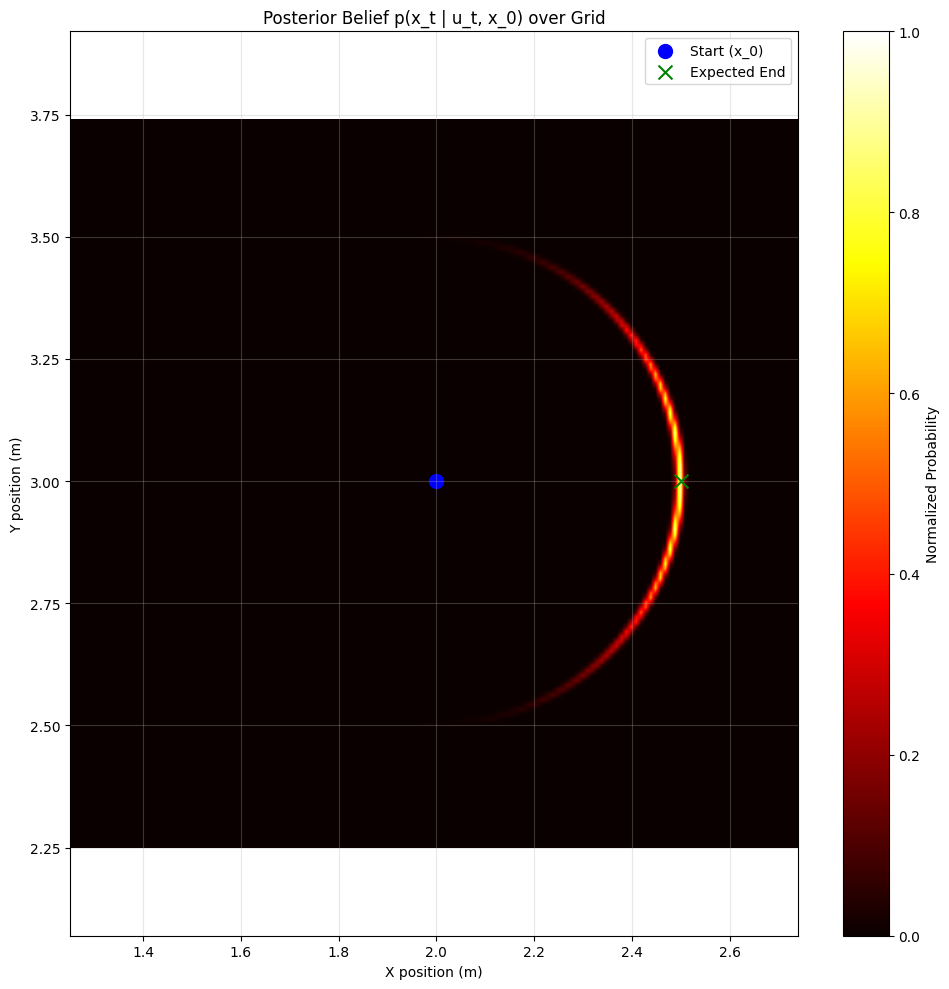

In [17]:
grid_size=150
resolution=0.01
x_center, y_center = 2.0, 3.0

#range of x and y. evenly spaced with steps of resolution
x_range = np.arange(x_center-grid_size/2*resolution, x_center+grid_size/2*resolution, resolution)
y_range = np.arange(y_center-grid_size/2 *resolution, y_center + grid_size/2 * resolution, resolution)

prob_grid = np.zeros((len(y_range), len(x_range)))

deltarot1_hat, deltatrans_hat, deltarot2 = inverse_motion_model(x_bar_0, x_bar_1)

for i, y in enumerate(y_range):
    for j, x in enumerate(x_range):
        theta_expected=x_0[2]+deltarot1_hat #starting orientation plus measured by odometry
        x_t=[x, y, theta_expected]
        
        deltarot1, deltatrans, deltarot2 = inverse_motion_model(x_0, x_t)
        
        sigma_rot1=alpha[0]*abs(deltarot1_hat)+alpha[1]*abs(deltatrans_hat)
        sigma_trans=alpha[2]*abs(deltatrans_hat)+alpha[3]*abs(deltarot1_hat)
        
        p1=prob_normal(deltarot1-deltarot1_hat, sigma_rot1)
        p2=prob_normal(deltatrans-deltatrans_hat, sigma_trans)
        
        prob_grid[i,j]=p1*p2

# Normalize
prob_grid=prob_grid/np.max(prob_grid)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(prob_grid, extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]], 
           origin='lower', cmap='hot', interpolation='bilinear')
plt.colorbar(label='Normalized Probability')
plt.scatter([x_0[0]], [x_0[1]], c='blue', s=100, marker='o', label='Start (x_0)')
plt.scatter([x_0[0] + 0.5], [x_0[1]], c='green', s=100, marker='x', label='Expected End')
plt.xlabel('X position (m)')    
plt.ylabel('Y position (m)')
plt.title('Posterior Belief p(x_t | u_t, x_0) over Grid')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()


## 4.3 Sample odometry motion model

The `motion_model_odometry` requires high computation complexity and does not scale well to large real-world environments. 

One effective approach to approximate $p(x_t | u_t, x_{t-1})$ is to use **sampling**.

The `sample_motion_model_odometry` function defines the sampling-based odometry motion model. 

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$ _(**map** coordinate frame)_
- the odometry readings $u_t = [\overline{x}_{t-1} \overline{x}_t]$ _(**odometry** coordinate frame)_
- the noise parameters $\mathbf{\alpha} = [\alpha_1, \alpha_2, \alpha_3, \alpha_4]$

The output is a new (sampled) pose predicted by the motion model.

Implement the `sample_motion_model_odometry` function and verify that it is correct for some test input. **[2.0]**

In [21]:
def sample_normal(b):
    # sample from gaussian distribution with std dev b, mean 0
    return np.random.normal(0, b)


def sample_motion_model_odometry(x_t_minus_1, u_t, alpha):
    # what wheels measured
    x_bar_t_minus_1=u_t[0]
    x_bar_t=u_t[1]

    # what motion sensors detected
    deltarot1_hat, deltatrans_hat, deltarot2_hat=inverse_motion_model(x_bar_t_minus_1,x_bar_t)

    # how much noise to add, sigma is how much error in rot1, trans, rot2
    sigma_rot1=alpha[0]*abs(deltarot1_hat)+alpha[1]*abs(deltatrans_hat)
    sigma_trans=alpha[2]*abs(deltatrans_hat)+alpha[3]*(abs(deltarot1_hat)+abs(deltarot2_hat))
    sigma_rot2=alpha[3]*abs(deltarot1_hat)+abs(deltarot2_hat)

    # adding some random noise
    deltarot1=deltarot1_hat-sample_normal(sigma_rot1)   # this is the sample normal distribution of error, so select one
    deltatrans=deltatrans_hat-sample_normal(sigma_trans)
    deltarot2=deltarot2_hat-sample_normal(sigma_rot2)
    # this will give us the actual rot1, trans, rot2 as we subtract error

    # get new postion using noisy motion
    x=x_t_minus_1[0]
    y=x_t_minus_1[1]
    theta=x_bar_t_minus_1[2]

    x_new=x+deltatrans*math.cos(theta+deltarot1)
    y_new=y+deltatrans*math.sin(theta+deltarot1)
    theta_new=theta+deltarot1+deltarot2

    # but we need to keep this theta in range of (-pi,pi)
    theta_new=math.atan2(math.sin(theta_new), math.cos(theta_new))

    return [x_new, y_new, theta_new]



In [22]:
# test samples
x_0=[2.0, 3.0, 0.0]
x_bar_0=[0.0, 0.0, 0.0]
x_bar_1=[0.5, 0.0, math.pi/2]
u_t=[x_bar_0, x_bar_1]
alpha=[1.0, 1.0, 0.01, 0.01]

print(f"Odometry: {x_bar_0} -> {x_bar_1}\n")

# take 10 samples. basically take 10 randome errors/noise in motion and give the predicted position using motion model
for i in range(10):
    x_sampled=sample_motion_model_odometry(x_0, u_t, alpha)
    print(f"Sample {i+1}: [{x_sampled[0]:.4f}, {x_sampled[1]:.4f}, {x_sampled[2]:.4f}]")




Odometry: [0.0, 0.0, 0.0] -> [0.5, 0.0, 1.5707963267948966]

Sample 1: [2.5052, 2.9681, 1.3111]
Sample 2: [2.4785, 2.8921, -0.7191]
Sample 3: [2.4346, 2.7326, 1.5499]
Sample 4: [2.4360, 2.7709, 2.0595]
Sample 5: [2.4768, 3.2092, 2.3253]
Sample 6: [2.4517, 3.2212, 1.4943]
Sample 7: [2.4995, 2.9616, 2.5909]
Sample 8: [2.5157, 2.9095, 2.6362]
Sample 9: [2.4799, 3.1089, 2.1784]
Sample 10: [2.4871, 3.1485, 0.0216]



Sample statistics:
mean position: [2.4384, 3.0115]
std dev position: [0.0831, 0.2276]
mean orientation: 0.4852 rad
std dev orientation: 1.7364 rad


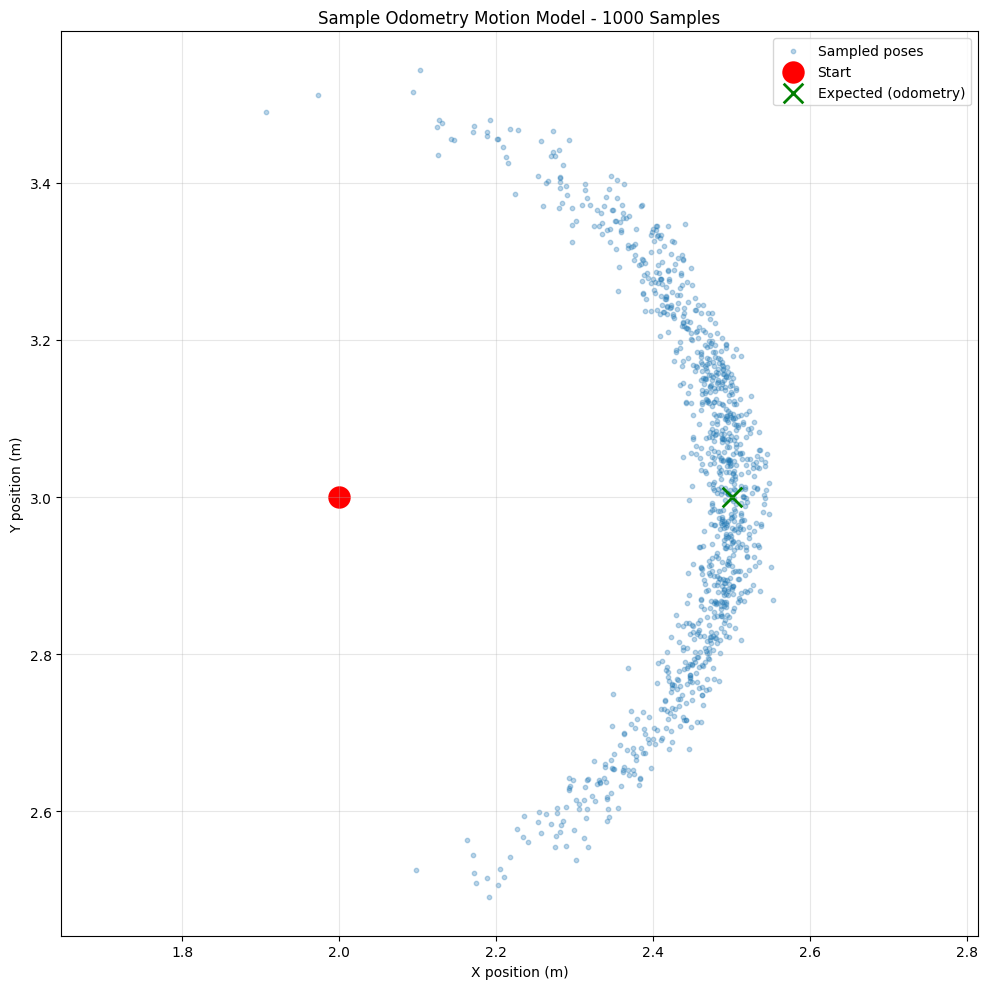

In [ ]:
# visualize these!!!! generating 1000 samples and plotting
samples=[]
for _ in range(1000):
    x_sampled=sample_motion_model_odometry(x_0, u_t, alpha)
    samples.append(x_sampled)

samples=np.array(samples)

# print stats
print(f"\nSample statistics:")
print(f"mean position: [{np.mean(samples[:, 0]):.4f}, {np.mean(samples[:, 1]):.4f}]")
print(f"std dev position: [{np.std(samples[:, 0]):.4f}, {np.std(samples[:, 1]):.4f}]")
print(f"mean orientation: {np.mean(samples[:, 2]):.4f} rad")
print(f"std dev orientation: {np.std(samples[:, 2]):.4f} rad")

#plot!!!!
plt.figure(figsize=(10, 10))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=10, label='Sampled poses')
plt.scatter([x_0[0]], [x_0[1]], c='red', s=200, marker='o', label='Start', linewidths=2)
plt.scatter([x_0[0] + 0.5], [x_0[1]], c='green', s=200, marker='x', label='Expected (odometry)', linewidths=2)
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.title('Sample Odometry Motion Model - 1000 Samples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()



## 4.4 Evaluate sample odometry motion model

Assume that a robot starts at pose $x_0 = [2.0, 3.0, 0.0]$ in the map frame and moves according to a motion model with $\mathbf{\alpha} = [0.1, 0.1, 0.01, 0.01]$.

The robot obtains the following odometry readings:

1. $\overline{x}_0 = [0.0 , 0.0 , 0.0   ]$
2. $\overline{x}_1 = [0.5 , 0.0 , \pi/2 ]$
3. $\overline{x}_2 = [0.5 , 0.5 , 0.0   ]$
4. $\overline{x}_3 = [1.0 , 0.5 , 0.0   ]$
5. $\overline{x}_4 = [1.0 , 1.5 , \pi/2 ]$
6. $\overline{x}_5 = [1.0 , 2.5 , \pi/2 ]$

Evaluate the `sample_motion_model_odometry` by considering 1000 samples and plot the resulting positions for each sample in one unique plot. **[3.0]**

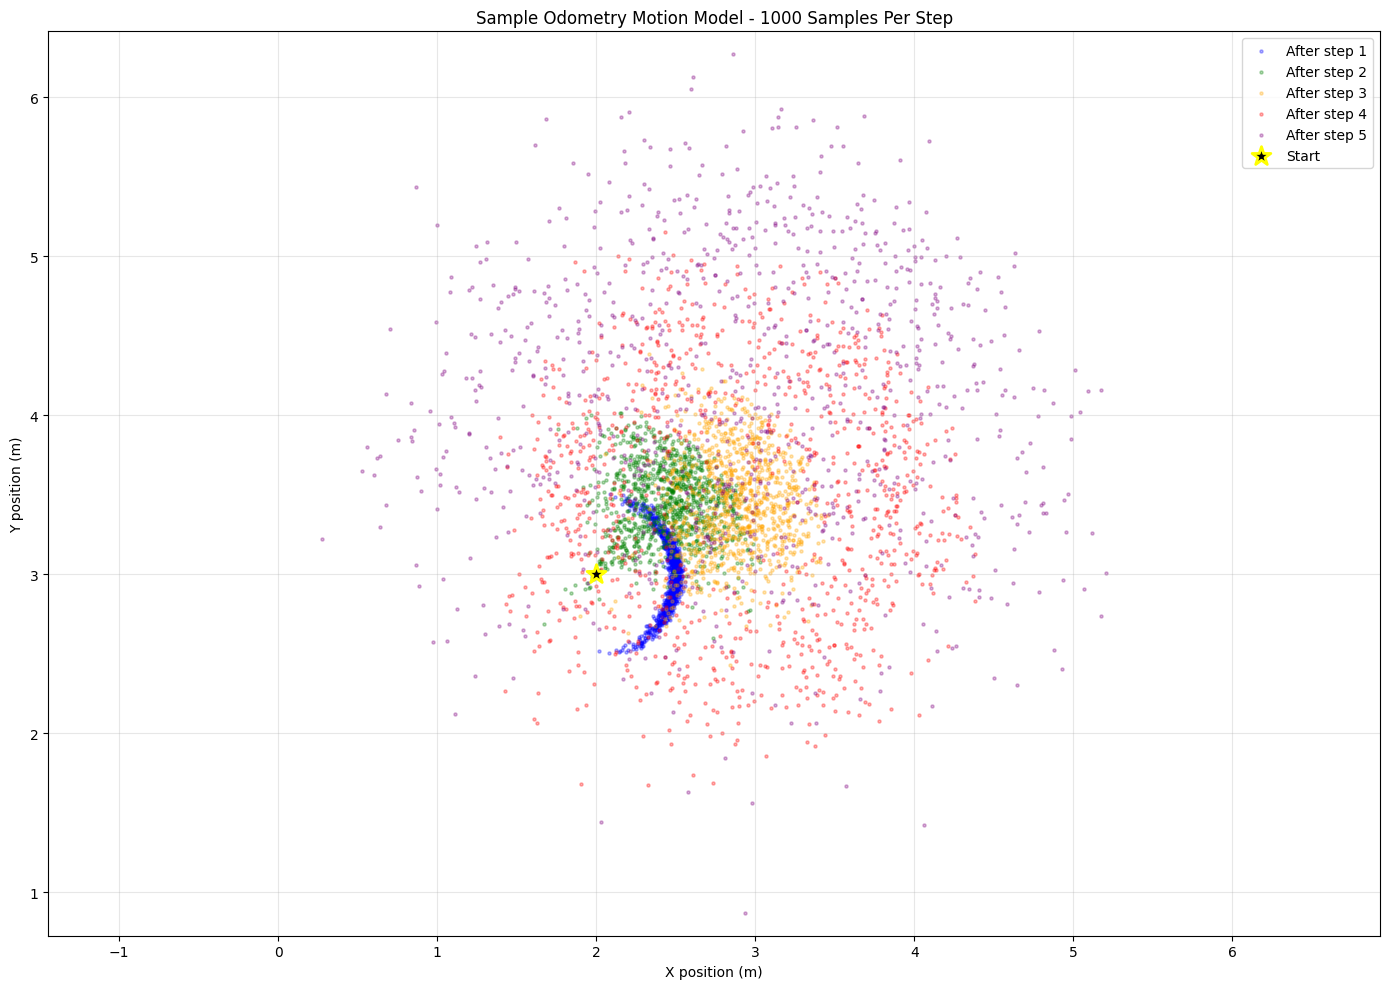

In [ ]:
# so we have 5 steps here. x0 to x1....., x4 to x5
x_bar_0=[0.0 , 0.0 , 0.0]
x_bar_1=[0.5 , 0.0 , math.pi/2]
x_bar_2=[0.5 , 0.5 , 0.0]
x_bar_3=[1.0 , 0.5 , 0.0]
x_bar_4=[1.0 , 1.5 , math.pi/2]
x_bar_5=[1.0 , 2.5 , math.pi/2]

sequence=[x_bar_0, x_bar_1, x_bar_2, x_bar_3, x_bar_4, x_bar_5]

all_samples=[]
num_samples=1000

for step in range(len(sequence)-1):
    step_samples=[]
    # loop through each odometry step
    for sample_num in range(num_samples):
        current_pose=x_0.copy()
        
        # apply all motions from start up to current step
        for motion_index in range(step+1):
            u_t=[sequence[motion_index], sequence[motion_index+1]]

            current_pose=sample_motion_model_odometry(current_pose,u_t,alpha)

        step_samples.append(current_pose)

    all_samples.append(step_samples)

plt.figure(figsize=(14, 10))
colors = ['blue', 'green', 'orange', 'red', 'purple']

for step_index, step_samples in enumerate(all_samples):
    samples_array = np.array(step_samples)
    plt.scatter(samples_array[:, 0], samples_array[:, 1], alpha=0.3, s=5, c=colors[step_index], label=f'After step {step_index + 1}')

# mark starting position
plt.scatter([x_0[0]], [x_0[1]], c='black', s=200, marker='*', label='Start', zorder=10, edgecolors='yellow', linewidths=2)

plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.title('Sample Odometry Motion Model - 1000 Samples Per Step')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()



